## Case Study: Menu & Recipe Orders Insights

#### Based on the data provided, our aim is to analyse the trend and identify the important performance metric that contributes toward total order performance.

In [79]:
# importing the necessary libraries
import psycopg2 as pg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Connect to postgresql database
conn = pg2.connect(
    host="datatest.c1st3pkospxj.eu-west-1.rds.amazonaws.com",
    database="datatest_forecaster",
    user="candidate",
    password="Gou5toB0X")

In [16]:
# import data from postgresql
df = pd.read_sql('SELECT menu_id, AVG(actual_number) AS actual_orders, AVG(forecasted_number) AS forecasted_orders, ROUND((AVG(actual_number)- AVG(forecasted_number)) / AVG(actual_number), 2) AS Ratio FROM orders_actual_forecast GROUP BY menu_id ORDER BY actual_orders DESC', conn)
# df

### Actual vs Estimated Order Number by Menu

This chart shows the comparison between the actual and estimated order, as well as the performance trend across the menu.
The chart on the lower part describes the percentage difference between actual and estimated number of orders.
We have identify the percentage difference as one of our KPI that can be used in for our analysis.
Based on the figures, we are able to see that there is no menu that managed to meet their forecasted number of orders.
The ratio grows as the actual number of orders descreases across the menu id. It seems like the estimated order number are have been over-forecasted more for the menu with less demand.

<img src="Actual Order vs Forecast by Menu.png">

*Visualization created using Tableau\
Sources: https://public.tableau.com/app/profile/nurulsaidi/viz/PartAnalysisMenu/ActualOrdervsForecast#1*

In [42]:
# actual order performances by menu
# top_nr = df.sort_values(by='actual_orders', ascending = False)
# fig,axs = plt.subplots(1, 1, figsize=(20,10))
# sns.barplot(x='menu_id', y='actual_orders', data = df, order= top_nr['menu_id'], palette='RdYlGn_r')
# plt.ylabel('Number of order',fontsize=14,fontweight="bold")
# plt.title('Actual Order performance by Menu',fontsize=18,fontweight="bold")
# # sns.barplot(x='menu_id', y='percentage', data = df, order= bottom_10['menu_id'], ax=axs[1], palette='GnBu')
# plt.show()

### Actual vs Estimated Order Number by Recipe

We observed the similar trend for the percentage difference between actual and estimated number of orders across the recipe.

<img src="Actual Order vs Forecast by Recipe.png">

*Visualization created using Tableau\
Sources: https://public.tableau.com/app/profile/nurulsaidi/viz/PartAnalysisMenu/ActualOrdervsForecast#1*

Since every menu consist of multiple recipe combination, we further analyse the total number of recipe combination across all menus. From the graph below, we have identify only one outlier where menu id : 46 consists less than half number of recipe in the combination compared to the rest of the menu available.

Text(0.5, 1.0, 'Total Combination Number of Recipe by Menu')

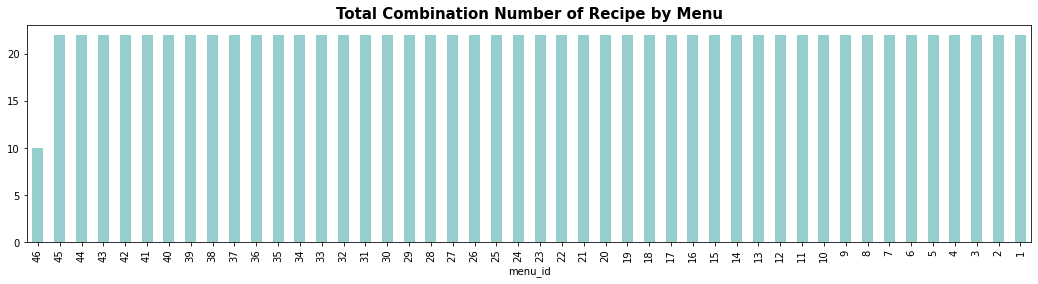

In [30]:
# Determine the number of recipe for every menu.

df_recipepermenu = pd.read_sql('SELECT distinct(menu_id), sum(count(recipe_id)) OVER (PARTITION BY menu_id ORDER BY menu_id) AS Total_recipe FROM orders_actual_forecast GROUP BY menu_id, recipe_id ORDER BY menu_id DESC', conn)
df_recipepermenu.plot.bar(x = 'menu_id', y ='total_recipe', color = '#96CDCD', figsize = (18,4), legend = None)
# # sns.boxplot(x = 'menu_id', y ='total_recipe', data = df_recipepermenu, palette='RdYlGn_r')
plt.title('Total Combination Number of Recipe by Menu',fontsize=15,fontweight="bold")
# df_recipepermenu

### Menu Mix Recipe Combination

By categorizing the recipe based on above and below average order performances, we analyze the recipe combination mix across the menu to observe the relationship between recipe combination and the demand trend.

<img src="Menu Recipe Mix Combination.png">

*Visualization created using Tableau\
Sources: https://public.tableau.com/app/profile/nurulsaidi/viz/PartAnalysisMenu/ActualOrdervsForecast#1*

In [78]:
# Recipe performance across menu

# df_avgrecipe = pd.read_sql("SELECT DISTINCT(recipe_id) , AVG(actual_number) OVER (PARTITION BY recipe_id) AS average_actual_orders FROM orders_actual_forecast GROUP BY recipe_id, actual_number ORDER BY average_actual_orders", conn)

# # average number of recipe id performance across all menus
# avg_recipe = df_avgrecipe.sort_values(by='average_actual_orders', ascending = False).head(20)
# avg_recipe['recipe_id'] = avg_recipe['recipe_id'].astype('category')
# fig,axs = plt.subplots(figsize=(15,8))
# sns.barplot(x='average_actual_orders', y='recipe_id', data = avg_recipe,order= avg_recipe['recipe_id'], palette='Wistia_r')
# sns.despine(left=True, bottom=True)
# # plt.ylabel('Average Number of order',fontsize=14,fontweight="bold")
# plt.title('Top 20 Recipe performance across Menu',fontsize=15,fontweight="bold")
# plt.tight_layout()

In [77]:
# import data of total orders by recipe and recipe title.

df_recipetitle = pd.read_sql("SELECT DISTINCT(recipe_id), title , AVG(value) OVER (PARTITION BY recipe_id) AS average_actual_orders  FROM tbl_orders_actual_wmenu ORDER BY average_actual_orders  DESC", conn)
df_recipetitle.head(10)

,recipe_id,title,average_actual_orders
0,230,Thai Chicken Noodles,7186.000000
1,2,Simple Chicken Red Curry,6677.933333
2,80,Fragrant Chicken Stir Fry,6431.750000
3,313,Thai Chicken Red Curry,6412.466667
4,315,Speedy Steak Green Curry,5900.800000
5,130,Spicy Beef Pad Thai,5801.800000
6,245,Thai Beef Green Curry,5357.900000
7,220,Simple Beef Noodles,5341.444444
8,302,Thai Steak Green Curry,5192.333333
9,115,Quick Chicken Rogan Josh,5054.400000


<img src="Recipe Info.png">

*Visualization created using Tableau\
Sources: https://public.tableau.com/app/profile/nurulsaidi/viz/PartAnalysisMenu/ActualOrdervsForecast#1*

In [49]:
# import data of total orders by box type, collections, cuisines and protein. 

# box type df
df_boxtype = pd.read_sql("SELECT B.description, SUM(value) as Order_Number FROM tbl_orders_actual_wmenu A JOIN box_types B on A.box_type_id = B.id GROUP BY description", conn)
# collections df
df_collections = pd.read_sql("SELECT B.description, SUM(value) as Order_Number FROM tbl_orders_actual_wmenu A JOIN collections B on A.collection_id = B.id GROUP BY description", conn)
# cuisines df
df_cuisines = pd.read_sql("SELECT B.description, SUM(value) as Order_Number FROM tbl_orders_actual_wmenu A JOIN cuisines B on A.cuisine_id = B.id GROUP BY description ORDER BY Order_Number DESC", conn)
# proteins df
df_proteins = pd.read_sql("SELECT B.description, SUM(value) as Order_Number FROM tbl_orders_actual_wmenu A JOIN proteins B on A.protein_id = B.id GROUP BY description ORDER BY Order_Number DESC", conn)

<AxesSubplot:ylabel='order_number'>

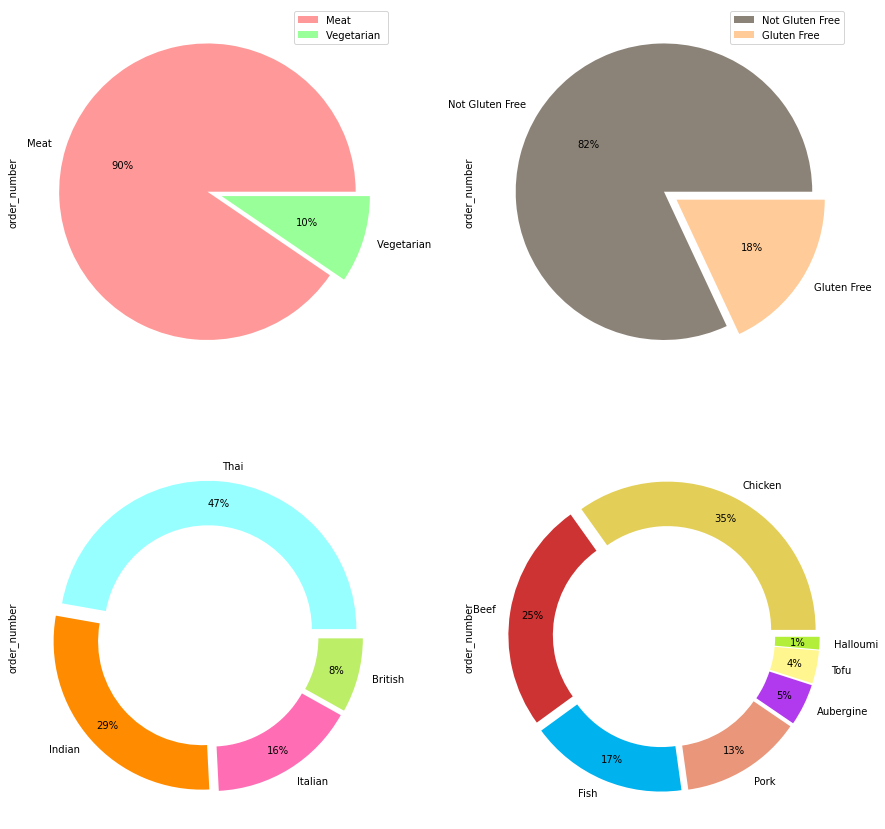

In [58]:
# create pie chart of total orders by box type, collections, cuisines and protein.
plt.figure(figsize=(15,15))
plt.tight_layout()
# plt.subplots(2, 1, figsize=(15,15))
ax1 = plt.subplot(221, aspect='equal')
ax2 = plt.subplot(222, aspect='equal')
ax3 = plt.subplot(223, aspect='equal')
ax4 = plt.subplot(224, aspect='equal')
df_boxtype.plot.pie(y = 'order_number', labels = df_boxtype['description'] ,ax = ax1, explode = (0, 0.1) ,autopct='%.0f%%' , colors = ['#ff9999','#99ff99'])
df_collections.plot.pie(y = 'order_number', labels = df_collections['description'] ,ax = ax2, explode = (0, 0.1) ,autopct='%.0f%%' , colors = ['#8B8378','#ffcc99'] )
df_cuisines.plot.pie(y = 'order_number', labels = df_cuisines['description'] ,ax = ax3 ,wedgeprops=dict(width=.3),pctdistance=0.85,explode = (0.05,0.05,0.05,0.05),colors = ['#97FFFF','#FF8C00','#FF6EB4','#BCEE68'], autopct='%.0f%%' , legend=False)
df_proteins.plot.pie(y = 'order_number', labels = df_proteins['description'] ,ax = ax4 ,wedgeprops=dict(width=.3),pctdistance=0.85,explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05),colors = ['#E3CF57','#CD3333','#00B2EE','#E9967A','#B23AEE','#FFF68F','#B3EE3A'], autopct='%.0f%%', legend=False )

Above pie charts desribe the demand based on ingredients and type of cuisines. Menus with high number of orders most potentially consist of the most preferred ingredients and cuisines type by customer.

### Recommendation

Optimal forecasting model requires high accuracy of predictive trend based on customer behaviour and demand elesticity.
From this analysis, we can focus on creating a better combination of recipes in the menu to increase sales.
It is also equaly important to determine the incremental impacts of new menu initiatives and to plan resources in response to expected demand. 

There are other important factors that have not be considered in this analysis including the seasonality trend, pricing and promotion activities, sales distribution channel, resources constraint and others.

### Conclusion

As our conclusion, based on this analysis we can identify what we should add or remove from the menu in terms of ingredient choice and cuisines types.

In [25]:
conn.close ()